✅ Voltage traces saved to voltage___traces.csv


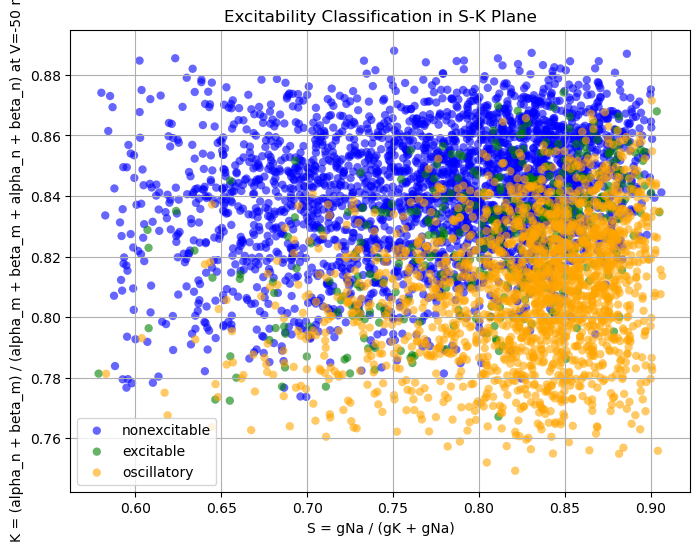

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

# 1. Baseline Parameters
BASE_PARAMS = {
    "Cm":   1.0,
    "gNa":  120.0,
    "gK":   36.0,
    "gL":   0.3,
    "ENa":  50.0,
    "EK":  -77.0,
    "EL":  -54.387
}

# 2. Parameter Ranges
PARAM_RANGES = {
    "Cm":  (0.8, 1.5),
    "ENa": (30.0, 54.0),
    "EK":  (-79.0, -74.0),
    "EL":  (-61.0, -43.0),
    "gNa": (65.0, 260.0),
    "gK":  (26.0, 49.0),
    "gL":  (0.1, 0.5)
}

# 3. Gating Rates
def alpha_m(V):
    return np.where(np.abs(V + 40) < 1e-7, 1.0, 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10)))
def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)
def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V):
    return 1.0 / (1 + np.exp(-(V + 35) / 10))
def alpha_n(V):
    return np.where(np.abs(V + 55) < 1e-7, 0.1, 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10)))
def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

# 4. HH Model ODEs
def hh_model(state, t, params, rate_scales, I_ext_func):
    V, m, h, n = state
    Cm, gNa, gK, gL, ENa, EK, EL = [params[k] for k in ["Cm", "gNa", "gK", "gL", "ENa", "EK", "EL"]]

    a_m = rate_scales["alpha_m"] * alpha_m(V)
    b_m = rate_scales["beta_m"] * beta_m(V)
    a_h = rate_scales["alpha_h"] * alpha_h(V)
    b_h = rate_scales["beta_h"] * beta_h(V)
    a_n = rate_scales["alpha_n"] * alpha_n(V)
    b_n = rate_scales["beta_n"] * beta_n(V)

    I_Na = gNa * (m**3) * h * (V - ENa)
    I_K  = gK * (n**4) * (V - EK)
    I_L  = gL * (V - EL)

    dVdt = (I_ext_func(t) - I_Na - I_K - I_L) / Cm
    dmdt = a_m * (1 - m) - b_m * m
    dhdt = a_h * (1 - h) - b_h * h
    dndt = a_n * (1 - n) - b_n * n

    return [dVdt, dmdt, dhdt, dndt]

# 5. External Current
def I_ext_func(t, I_stim=0.7, t_stim_on=50.0, pulse_width=1.0):
    return I_stim if (t_stim_on <= t < t_stim_on + pulse_width) else 0.0

# 6. Simulation
def simulate_HH(params, rate_scales, dt=0.01, tmax=150.0,
                I_stim=0.7, t_stim_on=50.0, pulse_width=1.0):
    t = np.arange(0, tmax, dt)
    V0 = -65.0
    state0 = [
        V0,
        alpha_m(V0) / (alpha_m(V0) + beta_m(V0)),
        alpha_h(V0) / (alpha_h(V0) + beta_h(V0)),
        alpha_n(V0) / (alpha_n(V0) + beta_n(V0))
    ]

    sol = odeint(
        hh_model, state0, t,
        args=(params, rate_scales,
              lambda time: I_ext_func(time, I_stim, t_stim_on, pulse_width))
    )
    return t, sol[:, 0]

# 7. Spike Counting
def count_spikes(V_trace, threshold=0.0):
    return len(np.where((V_trace[:-1] < threshold) & (V_trace[1:] >= threshold))[0])

def classify_outcome(V_trace, threshold=0.0):
    n_spikes = count_spikes(V_trace, threshold)
    if n_spikes == 0:
        return "nonexcitable"
    elif n_spikes == 1:
        return "excitable"
    else:
        return "oscillatory"

# 8. S and K calculations
def compute_S(params):
    return params["gNa"] / (params["gK"] + params["gNa"] + 1e-9)

def compute_K(rate_scales, Vref=-50.0):
    am, bm = alpha_m(Vref), beta_m(Vref)
    an, bn = alpha_n(Vref), beta_n(Vref)

    am_eff = rate_scales["alpha_m"] * am
    bm_eff = rate_scales["beta_m"] * bm
    an_eff = rate_scales["alpha_n"] * an
    bn_eff = rate_scales["beta_n"] * bn

    return (an_eff + bm_eff) / (am_eff + bm_eff + an_eff + bn_eff + 1e-9)

# 9. Run Simulations and Save Voltage Traces
def run_paper_style_sims(n_samples=5000, dt=0.01, tmax=150.0,
                         I_stim=0.7, t_stim_on=50.0, pulse_width=1.0,
                         Vref=-56.0):
    S_vals, K_vals = np.zeros(n_samples), np.zeros(n_samples)
    outcomes = np.empty(n_samples, dtype=object)

    t_vec = np.arange(0, tmax, dt)
    all_traces = []
    colnames = []

    for i in range(n_samples):
        params = {k: np.random.uniform(*PARAM_RANGES[k]) for k in PARAM_RANGES}
        rate_scales = {k: np.random.uniform(0.75, 1.25) for k in
                       ["alpha_m", "beta_m", "alpha_h", "beta_h", "alpha_n", "beta_n"]}

        t, V_trace = simulate_HH(params, rate_scales, dt, tmax,
                                 I_stim, t_stim_on, pulse_width)

        outcome = classify_outcome(V_trace)
        outcomes[i] = outcome
        S_vals[i] = compute_S(params)
        K_vals[i] = compute_K(rate_scales, Vref)

        group = {"nonexcitable": 0, "excitable": 1, "oscillatory": 2}[outcome]
        all_traces.append(V_trace)
        colnames.append(f"neuron_{i}_group{group}")

    # Save voltage traces to CSV
    df = pd.DataFrame(np.array(all_traces).T, index=t_vec, columns=colnames)
    df.index.name = "time"
    df.to_csv("voltage___traces2345.csv")
    print("✅ Voltage traces saved to voltage___traces2345.csv")

    return S_vals, K_vals, outcomes

# 10. Main Execution and Plot

S_vals, K_vals, outcomes = run_paper_style_sims(
    n_samples=5000,   # number of cells
    dt=0.01,           #step_size
    tmax=150.0,        # Maximum time period (millisecond)
    I_stim=0.7,        # External current injection(microamper)
    t_stim_on=50.0,    # time where current is injected
    pulse_width=1.0,   # The time that current should inject (50ms to 51ms)
    Vref=-56.0         # Reference membrane potential(millivoltage)
)

# Plotting the results
plt.figure(figsize=(8, 6))
color_map = {"nonexcitable": "blue", "excitable": "green", "oscillatory": "orange"}
for ctype in color_map:
    idx = (outcomes == ctype)
    plt.scatter(S_vals[idx], K_vals[idx], c=color_map[ctype],
                label=ctype, alpha=0.6, edgecolors='none')

plt.xlabel("S = gNa / (gK + gNa)")
plt.ylabel("K = (alpha_n + beta_m) / (alpha_m + beta_m + alpha_n + beta_n) at V=-50 mV")
plt.title("Excitability Classification in S-K Plane")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Same spike counting function as in your HH code
def count_spikes(V_trace, threshold=0.0):
    return len(np.where((V_trace[:-1] < threshold) & (V_trace[1:] >= threshold))[0])

# 1. Load the CSV file of voltage traces
df = pd.read_csv(r"C:\Users\moham\voltage___traces2345.csv", index_col=0)
print("Data shape:", df.shape)

# 2. Count spikes for each neuron (each column)
all_spike_counts = []
for neuron_col in df.columns:
    V_trace = df[neuron_col].values
    n_spikes = count_spikes(V_trace, threshold=0.0)
    all_spike_counts.append(n_spikes)

# 3. Find min and max spikes across all neurons
min_spikes = min(all_spike_counts)
max_spikes = max(all_spike_counts)

print(f"Minimum number of spikes across neurons: {min_spikes}")
print(f"Maximum number of spikes across neurons: {max_spikes}")


Data shape: (15000, 5000)
Minimum number of spikes across neurons: 0
Maximum number of spikes across neurons: 15


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter

def count_spikes(V_trace, threshold=0.0):
    return len(np.where((V_trace[:-1] < threshold) & (V_trace[1:] >= threshold))[0])

# 1. Load the CSV file of voltage traces
df = pd.read_csv(r"C:\Users\moham\voltage___traces2345.csv", index_col=0)
print("Data shape:", df.shape)

# 2. Count spikes for each neuron (each column)
all_spike_counts = []
for neuron_col in df.columns:
    V_trace = df[neuron_col].values
    n_spikes = count_spikes(V_trace, threshold=0.0)
    all_spike_counts.append(n_spikes)

# 3. Use Counter to find the frequency of each spike count
spike_counter = Counter(all_spike_counts)

# 4. Print out the distribution of spike counts
print("Spike Count Distribution:")
for spike_count in sorted(spike_counter.keys()):
    print(f"{spike_count} spikes -> {spike_counter[spike_count]} neurons")


Data shape: (15000, 5000)
Spike Count Distribution:
0 spikes -> 2776 neurons
1 spikes -> 375 neurons
2 spikes -> 2 neurons
3 spikes -> 5 neurons
4 spikes -> 6 neurons
5 spikes -> 19 neurons
6 spikes -> 82 neurons
7 spikes -> 234 neurons
8 spikes -> 364 neurons
9 spikes -> 399 neurons
10 spikes -> 318 neurons
11 spikes -> 240 neurons
12 spikes -> 121 neurons
13 spikes -> 46 neurons
14 spikes -> 9 neurons
15 spikes -> 4 neurons
